In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from tqdm.notebook import tqdm
import time

## Dynamic Time Warping

In [13]:
import numpy as np

def dtw_cons_md(t, r, win=np.inf, dist_metric='eu'):
    N = t.shape[1]  # If single source/dest
    M = r.shape[1]  # If single source/dest

    if np.isscalar(win):
        win = np.ones((2, 1)) * win

    Dist = np.inf
    d = np.full((N, M), np.inf)
    w1 = 0
    w2 = 0

    if dist_metric.startswith('cos') and t.shape[0] > 1:
        t_norm = np.sqrt(np.sum(np.square(t), axis=0))
        r_norm = np.sqrt(np.sum(np.square(r), axis=0))
        for n in range(N):
            for m in range(M):
                if (-win[0] < (n - m) < win[1]):
                    d[n, m] = 1 - np.dot(t[:, n], r[:, m]) / (t_norm[n] * r_norm[m])
    else:
        for n in range(N):
            for m in range(M):
                if (-win[0] < (n - m) < win[1]):
                    d[n, m] = np.sum((t[:, n] - r[:, m]) ** 2)

    
    D = np.zeros(d.shape)
    D[0,0] = d[0,0]

    for n in range(1, N):
        D[n, 0] = d[n, 0] + D[n-1, 0]

    for m in range(1, M):
        D[0, m] = d[0, m] + D[0, m-1]

    for n in range(1, N):
        for m in range(1, M):
            D[n, m] = d[n, m] + min(D[n-1, m], D[n-1, m-1], D[n, m-1])

    Dist = D[N-1, M-1]


    n = N
    m = M
    k = N + M
    w = np.zeros((N+M, 2), dtype=int)
    w[N+M-1, :] = [N, M]

    while (n+m) != 2:
        if (n-1) == 0:
            m = m-1
        elif (m-1) == 0:
            n = n-1
        else:
            number = np.argmin([D[n-2, m-1], D[n-1, m-2], D[n-2, m-2]]) + 1
            if number == 1:
                n = n-1
            elif number == 2:
                m = m-1
            elif number == 3:
                n = n-1
                m = m-1

        k = k-1
        w[k-1, :] = [n, m]

    w = w[k:, :]
    w1, w2 = w[:, 0], w[:, 1]

    return Dist



In [14]:
def shapelet_transform(vector, shapelet_array, slope_thres=0.0005):
    """
    Generate shapelet space representation for the given vector.
    
    Args:
    vector (array-like): Input vector.
    shapelet_array (numpy.ndarray): Array of shapelets.
    slope_thres (float, optional): Threshold for slope. Defaults to 0.0005.
    
    Returns:
    numpy.ndarray: Coordinates in the shapelet space.
    """
    ns, d = shapelet_array.shape
    coords = np.full(ns, np.nan)
    
    if len(vector) != d:
        return coords
    
    beta = -np.log(0.1) / slope_thres
    m0 = 0
    slope = np.mean(np.abs(np.diff(vector)))
    
    flatness = np.exp(-beta * (slope - m0)) if slope >= m0 else 1
    
    if slope_thres < 0:
        flatness = 0
    
    for i in range(ns):
        if not np.any(shapelet_array[i, :]):
            score = 2 * flatness - 1
        else:
            score = (1 - flatness) * similarity_non_flat(shapelet_array[i, :], vector)
        coords[i] = score
    
    return coords

def similarity_non_flat(v1, v2):
    """
    Calculate the similarity between two non-flat vectors.
    
    Args:
    v1 (array-like): First vector.
    v2 (array-like): Second vector.
    
    Returns:
    float: Similarity score.
    """
    if np.std(v1) < 1e-100 or np.std(v2) < 1e-100:
        return 0
    else:
        return np.corrcoef(v1, v2)[0, 1]


In [15]:
def shape_ts_transform(dd, A, slope_thres):
    ns, T = dd.shape
    d, w = A.shape
    nopad = 0  # 0 means pad the last w points
    all_reps = np.full((ns, T, d), np.nan)

    if np.isscalar(slope_thres):
        slope_thres = np.repeat(slope_thres, ns)

    l = int(np.ceil(w / 2)) - 1
    r = w - int(np.ceil(w / 2))  # moving window determined by left and right

    for cid in range(ns):
        for tt in range(l, T - r):
            all_reps[cid, tt, :] = shapelet_transform(dd[cid, tt-l:tt+r+1], A, slope_thres[cid])

        if nopad < 1:
            all_reps[cid, :l, :] = np.tile(all_reps[cid, l, :], (l, 1))
            all_reps[cid, T-r : T, :] = np.tile(all_reps[cid, T-r-1, :], (r, 1))

    return all_reps


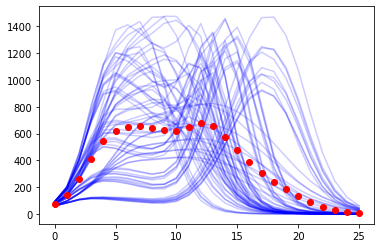

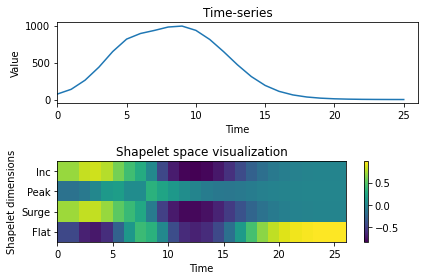

Computing Similarity Matrix, Please Wait ......................................


In [ ]:
# Load data from csv file
dd = pd.read_csv("flu_sims.csv").values
# Plot data with semi-transparent lines
dd = np.genfromtxt("flu_sims.csv", delimiter=',') 

plt.plot(dd.T, color=(0, 0, 1, 0.2))
plt.plot(np.nanmean(dd, axis=0), 'o', color='r')
plt.show()

A = np.array([
    [1, 2, 3, 4],
    [1, 2, 2, 1],
    [1, 2, 4, 8],
    [0, 0, 0, 0]
])

# Get dimensions of A and time series data
d, w = A.shape
ns, T = dd.shape

# Calculate slope thresholds
slope_time = T
slope_thres = np.zeros(ns)
for cid in range(ns):
    slope_thres[cid] = np.nanmax(np.convolve(np.abs(np.diff(dd[cid, :slope_time])), np.ones(d)/d, mode='valid'))
slope_thres[:] = np.nanmedian(slope_thres)

all_reps = shape_ts_transform(dd, A, slope_thres)

#print(all_reps)

# Plot a random time series and its shapelet space representation
cid = np.random.randint(0, ns)
fig, ax = plt.subplots(2, 1)
ax[0].plot(dd[cid, :])
ax[0].set_xlim([0, all_reps.shape[1]])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].set_title('Time-series')

img = ax[1].imshow(np.squeeze(all_reps[cid, :, :]).T, aspect='auto', extent=[0, all_reps.shape[1], 0, 4])
fig.colorbar(img, ax=ax[1], orientation='vertical')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Shapelet dimensions')
ax[1].set_yticks([0.5, 1.5, 2.5, 3.5])
ax[1].set_yticklabels(['Flat', 'Surge', 'Peak', 'Inc'])

ax[1].set_title('Shapelet space visualization')
plt.tight_layout()
plt.show()

# Find similarity matrix
win = 30
sim_mat = np.full((ns, ns), np.nan)

start_time = time.time()
print("Computing Similarity Matrix, Please Wait ......................................")
for ii in range(ns):
    for jj in range(ii+1):
        sim_mat[ii, jj] = dtw_cons_md(np.squeeze(all_reps[ii, :, :]).T, np.squeeze(all_reps[jj, :, :]).T, win, 'euc')
end_time = time.time()

print(f"Time taken: {end_time - start_time} seconds")


In [ ]:
all_reps[74,:,1]

In [ ]:
all_reps[:,:,0]

In [52]:
pd.DataFrame(sim_mat)

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.353712,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.964584,0.356604,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.369911,0.765211,0.338645,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.047773,1.074526,0.431094,0.302982,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,5.405553,6.193578,6.639096,7.374395,7.904925,16.573863,16.937857,17.986841,19.208985,20.485012,...,2.412106,3.733169,6.465745,5.103316,5.269167,0.000000,NaN,NaN,NaN,NaN
71,3.594409,3.862450,4.068869,4.452515,4.618318,12.488609,12.135115,12.546106,13.497293,14.390523,...,0.180822,0.937054,11.683388,8.274140,6.107189,1.775334,0.000000,NaN,NaN,NaN
72,3.217482,2.731472,2.761016,2.860578,3.215585,10.057386,9.626553,9.894033,10.705351,11.443720,...,0.632287,0.131490,14.624943,11.669772,8.368756,3.445234,0.843038,0.000000,NaN,NaN
73,6.132804,6.911401,7.346817,8.514524,8.608433,16.118780,16.345424,17.087790,18.040452,18.897241,...,12.518478,14.584844,0.422727,0.132257,0.882285,6.291432,9.914484,13.247437,0.00000,NaN
